In [ ]:
import pandas as pd

df = pd.read_csv("D:\Data science\Impact of different events on spending US\data\StateAndCategory.csv", parse_dates=['Date'])

# Quick look at structure
print("✅ Columns:", df.columns.tolist())
print("🧾 Data types:\n", df.dtypes)
df.head()

✅ Columns: ['Date', 'State', 'Category', 'Variable', 'Value']
🧾 Data types:
 Date        datetime64[ns]
State               object
Category            object
Variable            object
Value              float64
dtype: object


,Date,State,Category,Variable,Value
0,2019-10-06,Alabama,Alcohol,Dollars,23611285.0
1,2019-10-13,Alabama,Alcohol,Dollars,23220758.0
2,2019-10-20,Alabama,Alcohol,Dollars,21770283.0
3,2019-10-27,Alabama,Alcohol,Dollars,21956558.0
4,2019-11-03,Alabama,Alcohol,Dollars,23183482.0


In [ ]:
# Unique values in the Variable column
df['Variable'].unique()


array(['Dollars', 'Unit sales', 'Dollars last year',
       'Unit sales last year', 'Dollars 3 years ago',
       'Unit sales 3 years ago', 'Percent change dollars 1 year',
       'Percent change units 1 year', 'Percent change dollars 3 years',
       'Percent change units 3 years'], dtype=object)

In [ ]:
# Only current dollar sales
df_sales = df[df['Variable'] == 'Dollars'].copy()

# Drop 'Variable' column — no longer needed
df_sales.drop(columns=['Variable'], inplace=True)

# Confirm the filtered dataset
print("✅ Filtered dataset shape:", df_sales.shape)
df_sales.head()


✅ Filtered dataset shape: (88924, 4)


,Date,State,Category,Value
0,2019-10-06,Alabama,Alcohol,23611285.0
1,2019-10-13,Alabama,Alcohol,23220758.0
2,2019-10-20,Alabama,Alcohol,21770283.0
3,2019-10-27,Alabama,Alcohol,21956558.0
4,2019-11-03,Alabama,Alcohol,23183482.0


In [14]:
# Extract unique years from the Date column
unique_years = df_sales['Date'].dt.year.unique()

# Sort and print them
unique_years_sorted = sorted(unique_years)
print("Years present in dataset:", unique_years_sorted)

# Also print the min and max dates for clarity
print("Date range from {} to {}".format(df_sales['Date'].min().date(), df_sales['Date'].max().date()))


Years present in dataset: [2019, 2020, 2021, 2022, 2023]
Date range from 2019-10-06 to 2023-05-07


In [15]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create holiday calendar
cal = USFederalHolidayCalendar()

# Generate holidays for the full range
holiday_dates = cal.holidays(start='2019-01-01', end='2023-12-31')

# function to tag weeks based on these holidays
from datetime import timedelta

def classify_week(date, holidays):
    for h in holidays:
        if h - timedelta(days=7) <= date < h:
            return "Pre-Holiday Week"
        elif h <= date < h + timedelta(days=7):
            return "Holiday Week"
        elif h + timedelta(days=7) <= date < h + timedelta(days=14):
            return "Post-Holiday Week"
    return "Other"


# applying tag to my dataframe
df_sales['event_window'] = df_sales['Date'].apply(lambda x: classify_week(x, holiday_dates))

print(df_sales['event_window'].value_counts())


event_window
Other                40678
Post-Holiday Week    18447
Holiday Week         16555
Pre-Holiday Week     13244
Name: count, dtype: int64


        event_window         Value
0              Other  1.277843e+12
1  Post-Holiday Week  5.602044e+11
2       Holiday Week  5.079368e+11
3   Pre-Holiday Week  4.158852e+11


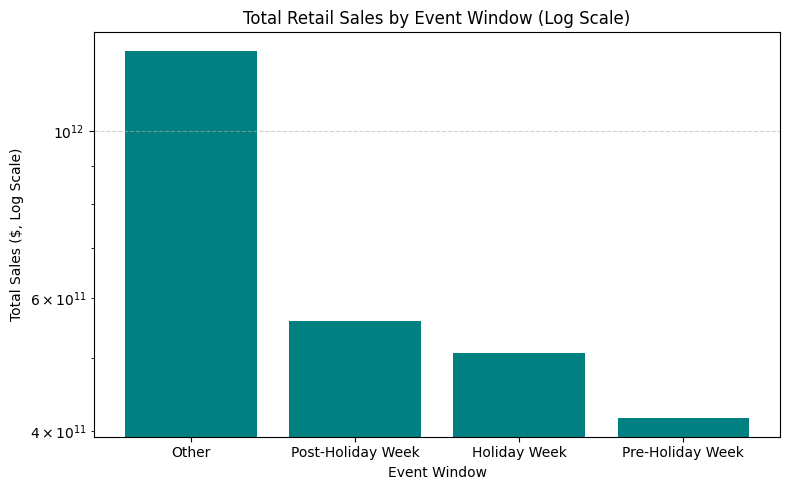

In [16]:
# Aggregating sales per holiday window
event_sales = (
    df_sales.groupby("event_window")["Value"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
print(event_sales)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(event_sales["event_window"], event_sales["Value"], color="teal")
plt.yscale("log")
plt.title("Total Retail Sales by Event Window (Log Scale)")
plt.ylabel("Total Sales ($, Log Scale)")
plt.xlabel("Event Window")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



In [17]:
# Count number of weeks per event window
weeks_count = df_sales.groupby("event_window")["Date"].nunique().reset_index()
weeks_count.rename(columns={"Date": "weeks_count"}, inplace=True)

# Sum sales per event window
sales_sum = df_sales.groupby("event_window")["Value"].sum().reset_index()

# Merge counts with sums
event_sales_norm = sales_sum.merge(weeks_count, on="event_window")

# Calculate average sales per week
event_sales_norm["avg_sales_per_week"] = event_sales_norm["Value"] / event_sales_norm["weeks_count"]

# Sort for better plotting
event_sales_norm = event_sales_norm.sort_values(by="avg_sales_per_week", ascending=False)

print(event_sales_norm)


        event_window         Value  weeks_count  avg_sales_per_week
1              Other  1.277843e+12           86        1.485864e+10
3   Pre-Holiday Week  4.158852e+11           28        1.485304e+10
0       Holiday Week  5.079368e+11           35        1.451248e+10
2  Post-Holiday Week  5.602044e+11           39        1.436422e+10


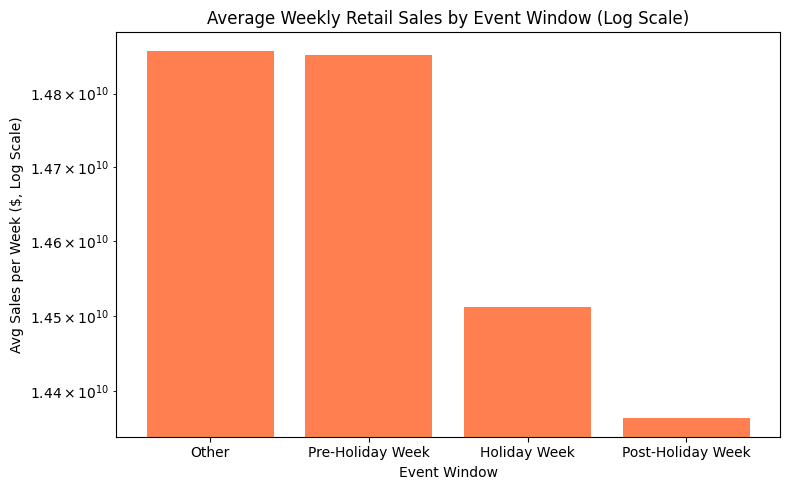

In [19]:
plt.figure(figsize=(8, 5))
plt.bar(event_sales_norm["event_window"], event_sales_norm["avg_sales_per_week"], color="coral")
plt.yscale("log")
plt.title("Average Weekly Retail Sales by Event Window (Log Scale)")
plt.ylabel("Avg Sales per Week ($, Log Scale)")
plt.xlabel("Event Window")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [22]:
df_sales.groupby("event_window")["week"].nunique()


event_window
Holiday Week         35
Other                86
Post-Holiday Week    39
Pre-Holiday Week     28
Name: week, dtype: int64

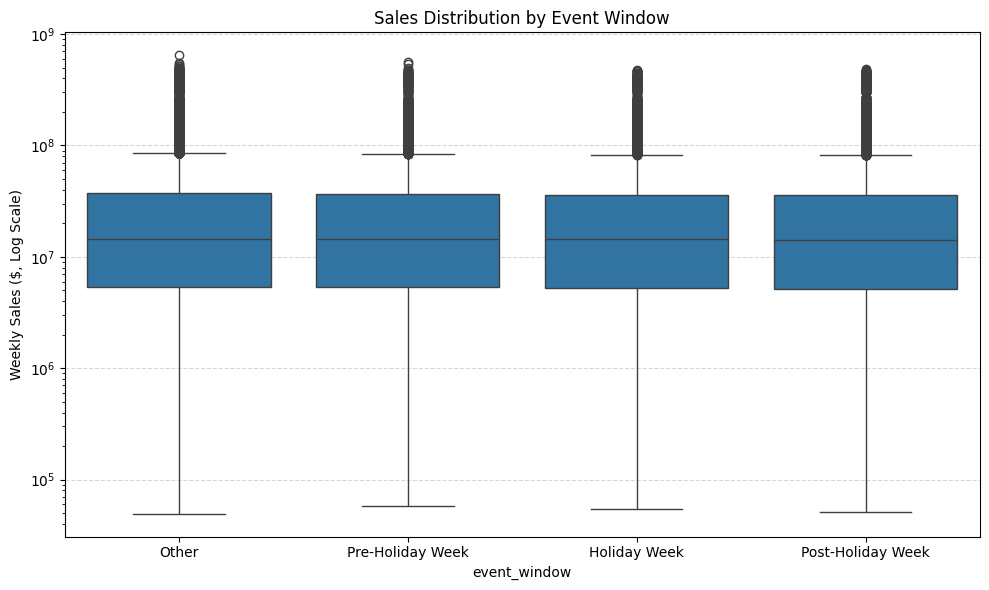

In [23]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sales, x="event_window", y="Value")
plt.yscale("log")
plt.title("Sales Distribution by Event Window")
plt.ylabel("Weekly Sales ($, Log Scale)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


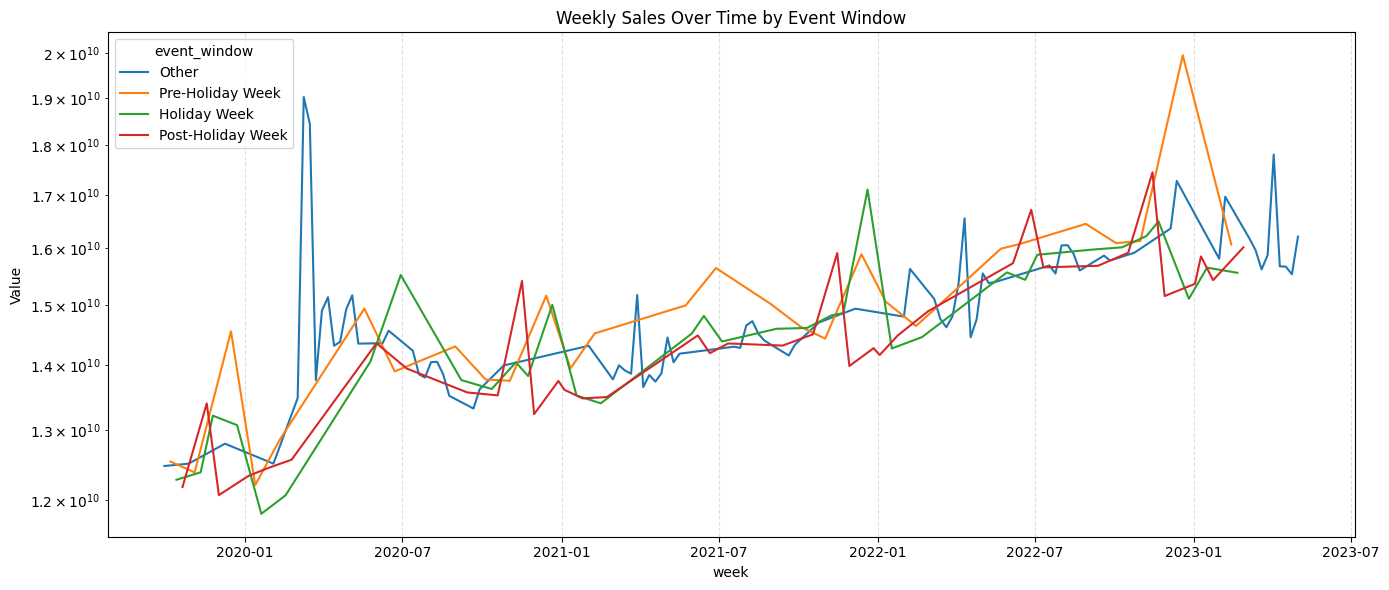

In [24]:
df_weekly = df_sales.groupby(["week", "event_window"])["Value"].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_weekly, x="week", y="Value", hue="event_window")
plt.yscale("log")
plt.title("Weekly Sales Over Time by Event Window")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


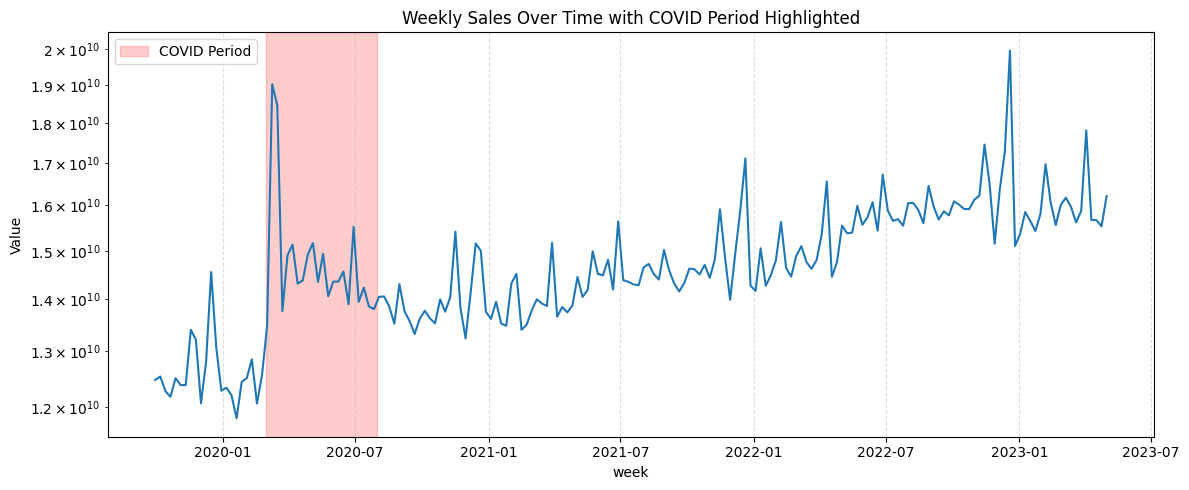

In [25]:
df_sales["covid_period"] = df_sales["week"].between("2020-03-01", "2020-07-31")

df_weekly = df_sales.groupby("week")["Value"].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_weekly, x="week", y="Value")
plt.axvspan(pd.to_datetime("2020-03-01"), pd.to_datetime("2020-07-31"), color="red", alpha=0.2, label="COVID Period")
plt.yscale("log")
plt.title("Weekly Sales Over Time with COVID Period Highlighted")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\zaect\AppData\Local\Temp\ipykernel_7624\3795374655.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


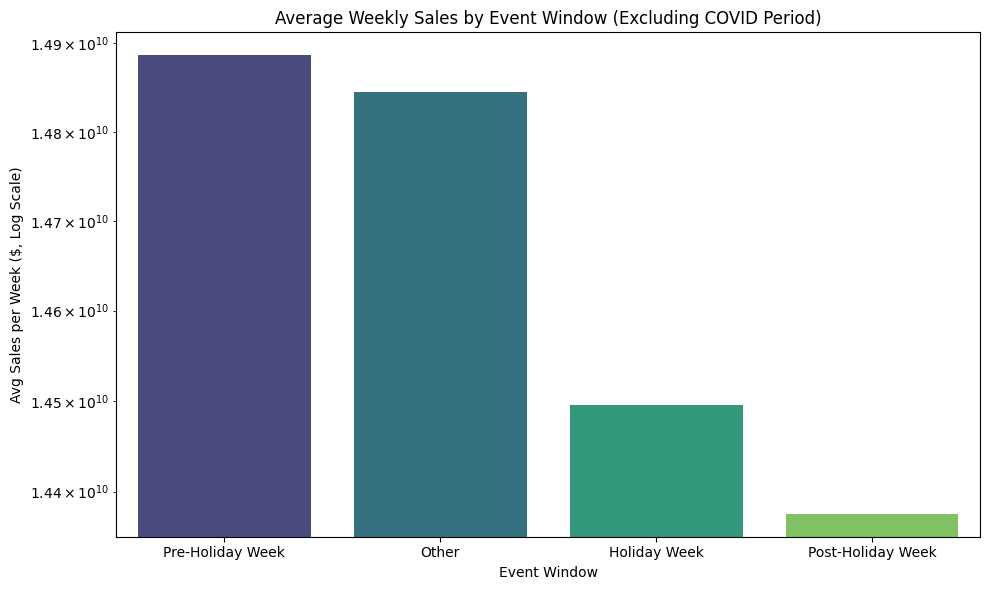

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 1. Flag COVID period in dataset
df_sales["week"] = df_sales["Date"].dt.to_period("W").apply(lambda r: r.start_time)
df_sales["covid_period"] = df_sales["week"].between("2020-03-01", "2020-07-31")

# ✅ 2. Filter out COVID-period data
df_filtered = df_sales[~df_sales["covid_period"]].copy()

# ✅ 3. Recalculate total Value and number of weeks per event window (excluding COVID period)
event_totals = df_filtered.groupby("event_window")["Value"].sum().reset_index()
week_counts = df_filtered.groupby("event_window")["week"].nunique().reset_index(name="weeks_count")

# ✅ 4. Merge and compute average sales per week
event_summary = pd.merge(event_totals, week_counts, on="event_window")
event_summary["avg_sales_per_week"] = event_summary["Value"] / event_summary["weeks_count"]

# ✅ 5. Plot average sales per week with log scale
plt.figure(figsize=(10, 6))
sns.barplot(
    data=event_summary.sort_values("avg_sales_per_week", ascending=False),
    x="event_window",
    y="avg_sales_per_week",
    palette="viridis"
)
plt.yscale("log")
plt.title("Average Weekly Sales by Event Window (Excluding COVID Period)")
plt.ylabel("Avg Sales per Week ($, Log Scale)")
plt.xlabel("Event Window")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\zaect\AppData\Local\Temp\ipykernel_7624\1840747687.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


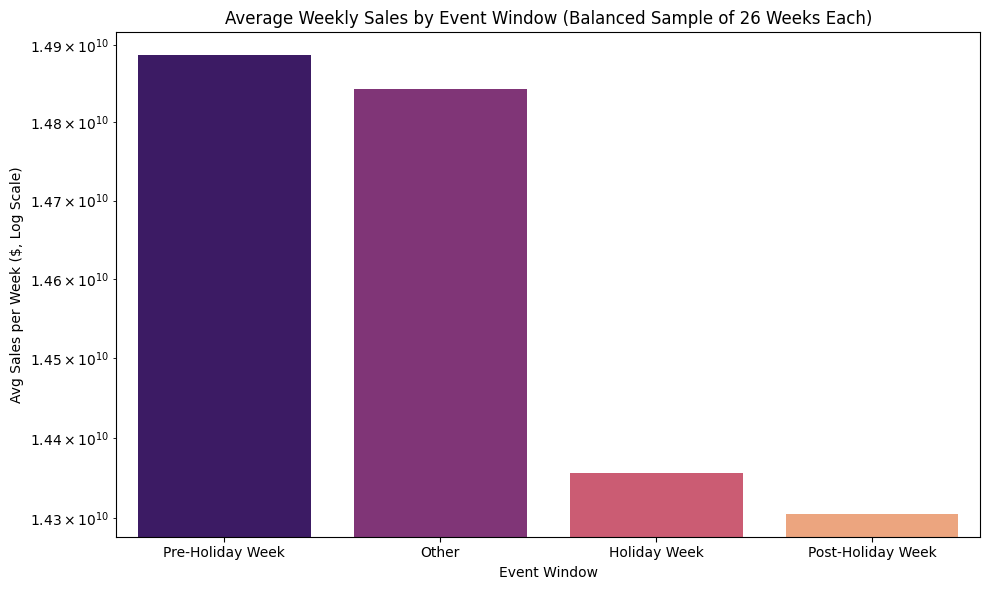

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Find minimum number of weeks across event windows
min_weeks = df_filtered.groupby("event_window")["week"].nunique().min()

balanced_samples = []

# 2. Sample equal weeks from each event window
for window in df_filtered["event_window"].unique():
    weeks = df_filtered[df_filtered["event_window"] == window]["week"].unique()
    sampled_weeks = np.random.choice(weeks, size=min_weeks, replace=False)
    sampled_data = df_filtered[(df_filtered["event_window"] == window) & (df_filtered["week"].isin(sampled_weeks))]
    balanced_samples.append(sampled_data)

balanced_df = pd.concat(balanced_samples)

# 3. Aggregate total sales and count weeks for balanced data
event_totals = balanced_df.groupby("event_window")["Value"].sum().reset_index()
week_counts = balanced_df.groupby("event_window")["week"].nunique().reset_index(name="weeks_count")

# 4. Calculate average sales per week on balanced sample
event_summary = pd.merge(event_totals, week_counts, on="event_window")
event_summary["avg_sales_per_week"] = event_summary["Value"] / event_summary["weeks_count"]

# 5. Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(
    data=event_summary.sort_values("avg_sales_per_week", ascending=False),
    x="event_window",
    y="avg_sales_per_week",
    palette="magma"
)
plt.yscale("log")
plt.title(f"Average Weekly Sales by Event Window (Balanced Sample of {min_weeks} Weeks Each)")
plt.ylabel("Avg Sales per Week ($, Log Scale)")
plt.xlabel("Event Window")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\zaect\AppData\Local\Temp\ipykernel_7624\526286334.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weekly_sales, x="event_window", y="Value", palette="Set2")


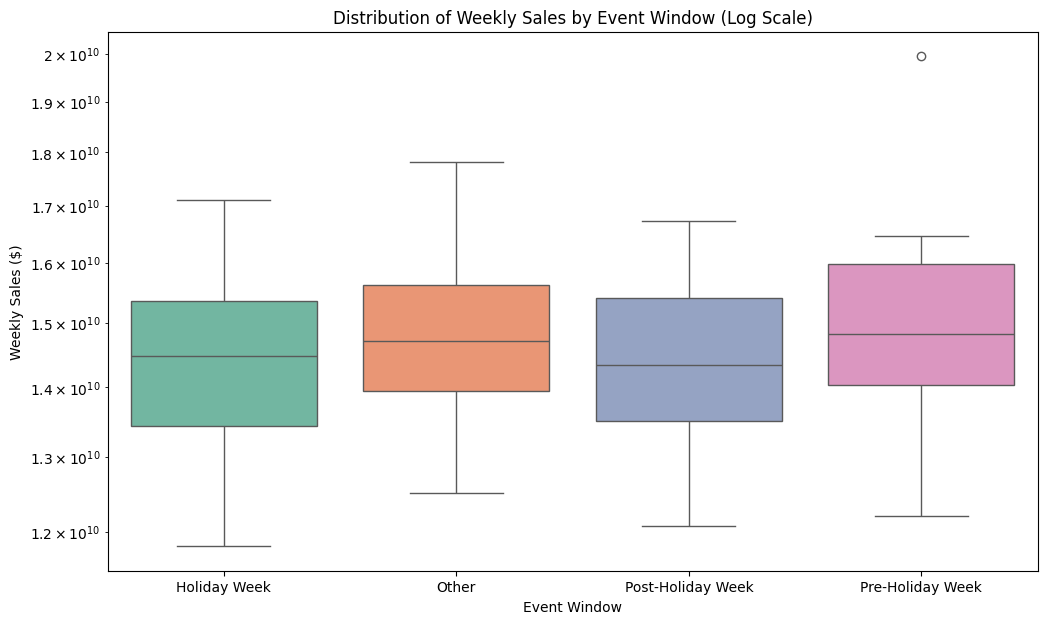

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate weekly sales per event_window and week
weekly_sales = balanced_df.groupby(["event_window", "week"])["Value"].sum().reset_index()

plt.figure(figsize=(12, 7))
sns.boxplot(data=weekly_sales, x="event_window", y="Value", palette="Set2")
plt.yscale('log')  # Log scale to handle large variance
plt.title("Distribution of Weekly Sales by Event Window (Log Scale)")
plt.ylabel("Weekly Sales ($)")
plt.xlabel("Event Window")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


C:\Users\zaect\AppData\Local\Temp\ipykernel_7624\2728344637.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary.sort_values("mean", ascending=False), x="event_window", y="mean", palette="viridis")


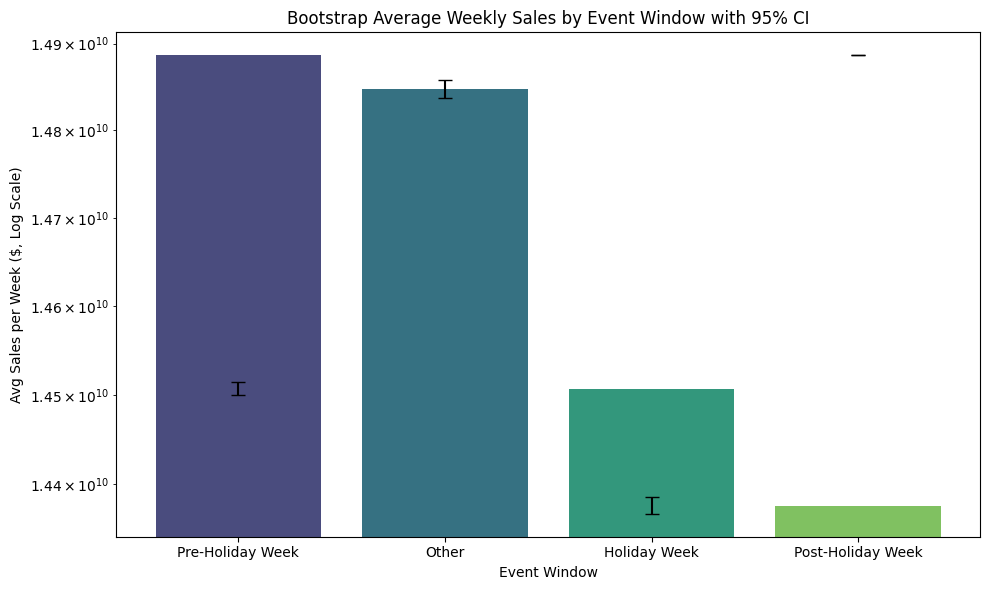

In [31]:
import numpy as np

n_iterations = 1000
min_weeks = balanced_df.groupby("event_window")["week"].nunique().min()
boot_results = []

for i in range(n_iterations):
    samples = []
    for window in df_filtered["event_window"].unique():
        weeks = df_filtered[df_filtered["event_window"] == window]["week"].unique()
        sampled_weeks = np.random.choice(weeks, size=min_weeks, replace=False)
        sampled_data = df_filtered[(df_filtered["event_window"] == window) & (df_filtered["week"].isin(sampled_weeks))]
        samples.append(sampled_data)
    boot_df = pd.concat(samples)
    agg = boot_df.groupby("event_window")["Value"].sum().reset_index()
    week_counts = boot_df.groupby("event_window")["week"].nunique().reset_index(name="weeks_count")
    merged = pd.merge(agg, week_counts, on="event_window")
    merged["avg_sales_per_week"] = merged["Value"] / merged["weeks_count"]
    merged["iteration"] = i
    boot_results.append(merged[["event_window", "avg_sales_per_week", "iteration"]])

boot_df_results = pd.concat(boot_results)

# Calculate mean and 95% confidence intervals
summary = boot_df_results.groupby("event_window")["avg_sales_per_week"].agg(['mean', 'std']).reset_index()
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(n_iterations))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(n_iterations))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary.sort_values("mean", ascending=False), x="event_window", y="mean", palette="viridis")
plt.errorbar(x=range(len(summary)), y=summary["mean"], 
             yerr=[summary["mean"] - summary["ci_lower"], summary["ci_upper"] - summary["mean"]],
             fmt='none', c='black', capsize=5)
plt.yscale("log")
plt.title("Bootstrap Average Weekly Sales by Event Window with 95% CI")
plt.ylabel("Avg Sales per Week ($, Log Scale)")
plt.xlabel("Event Window")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


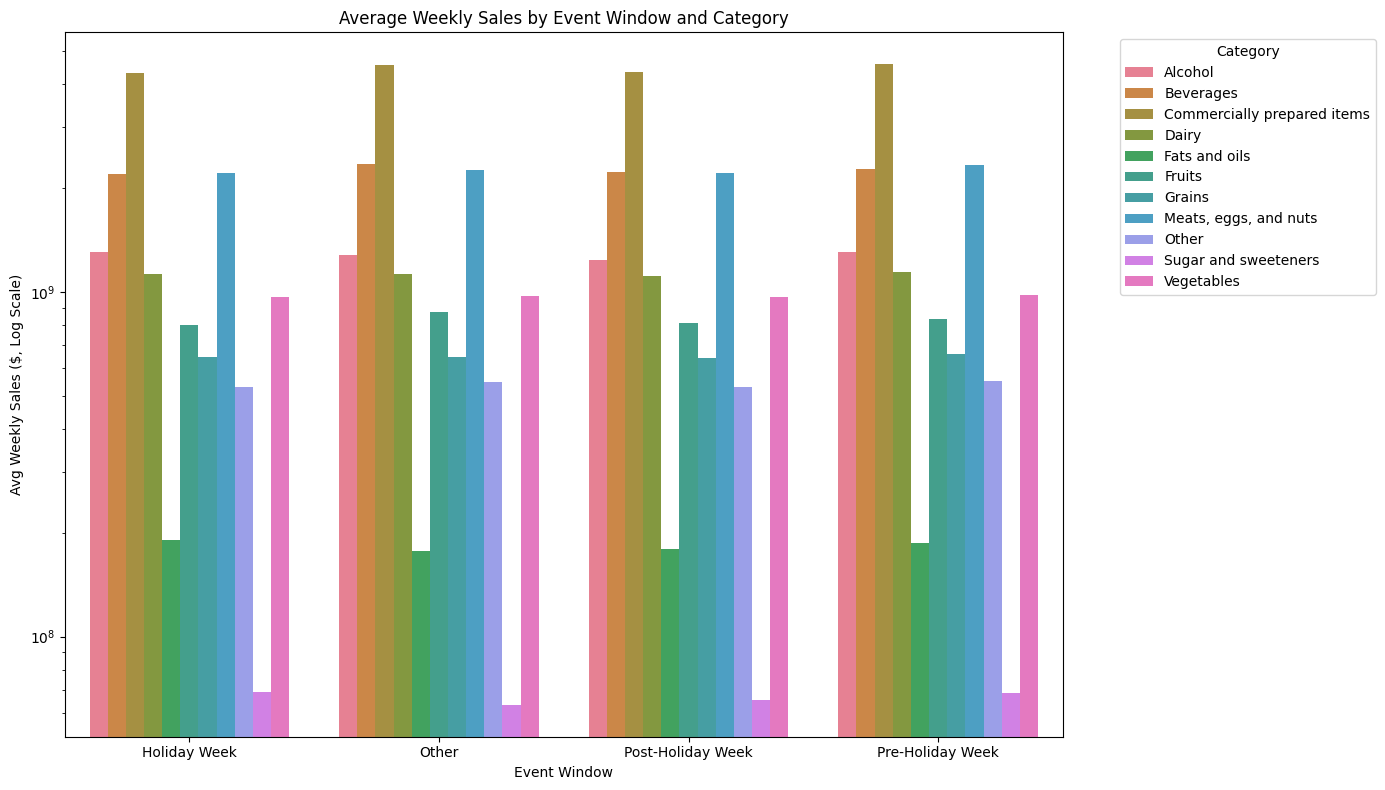

In [32]:
# Aggregate weekly sales by event_window and category
category_weekly_sales = balanced_df.groupby(["event_window", "Category", "week"])["Value"].sum().reset_index()

# Average weekly sales by event_window and category
category_avg = category_weekly_sales.groupby(["event_window", "Category"])["Value"].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=category_avg, x="event_window", y="Value", hue="Category")
plt.yscale("log")
plt.title("Average Weekly Sales by Event Window and Category")
plt.ylabel("Avg Weekly Sales ($, Log Scale)")
plt.xlabel("Event Window")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Flag COVID period and filter it out
df_sales["week"] = df_sales["Date"].dt.to_period("W").apply(lambda r: r.start_time)
df_sales["covid_period"] = df_sales["week"].between("2020-03-01", "2020-07-31")
df_filtered = df_sales[~df_sales["covid_period"]].copy()

# 2. Aggregate weekly sales by event_window, Category, and week
category_weekly_sales_filtered = df_filtered.groupby(["event_window", "Category", "week"])["Value"].sum().reset_index()

# 3. Calculate average weekly sales by event_window and Category
category_avg_filtered = category_weekly_sales_filtered.groupby(["event_window", "Category"])["Value"].mean().reset_index()

# 4. Get baseline ('Other') sales per Category
baseline = category_avg_filtered[category_avg_filtered['event_window'] == 'Other'][['Category', 'Value']].rename(columns={'Value': 'baseline'})

# 5. Merge baseline to all event windows, calculate pct_change
category_pct_change_filtered = category_avg_filtered.merge(baseline, on='Category')
category_pct_change_filtered['pct_change'] = ((category_pct_change_filtered['Value'] - category_pct_change_filtered['baseline']) / category_pct_change_filtered['baseline']) * 100

# 6. Pivot to make a neat table
event_table_filtered = category_pct_change_filtered.pivot(index='Category', columns='event_window', values='pct_change').round(1)

# Display table (if Jupyter)
from IPython.display import display
display(event_table_filtered.style.background_gradient(cmap='RdYlGn', axis=None))


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.500000,0.000000,-4.600000,1.400000
Beverages,-6.200000,0.000000,-6.500000,-4.200000
Commercially prepared items,-4.200000,0.000000,-4.100000,0.400000
Dairy,1.000000,0.000000,-0.000000,1.700000
Fats and oils,8.000000,0.000000,2.300000,5.500000
Fruits,-6.300000,0.000000,-6.000000,-4.400000
Grains,0.200000,0.000000,-0.500000,1.400000
"Meats, eggs, and nuts",-0.700000,0.000000,-1.200000,3.400000
Other,-1.300000,0.000000,-1.400000,1.100000


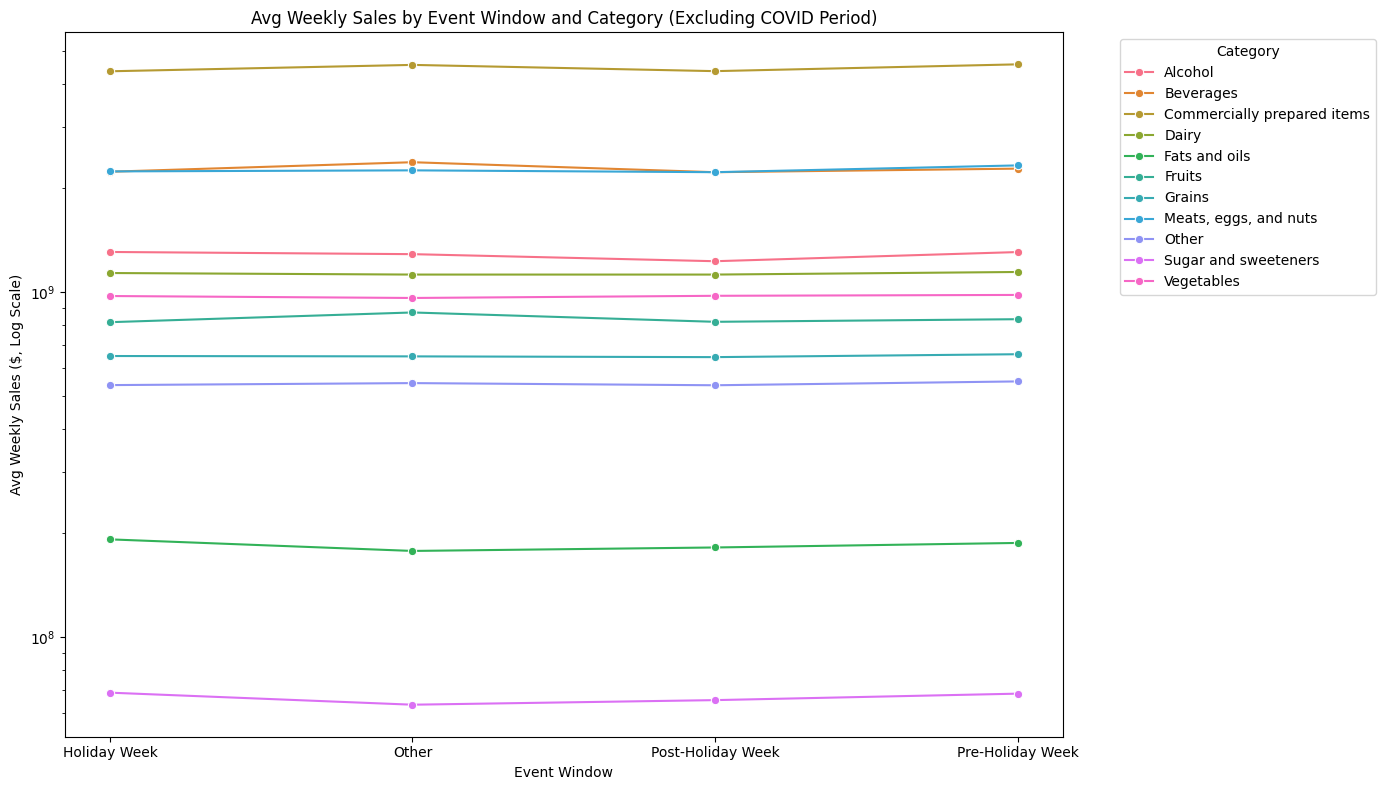

In [46]:
plt.figure(figsize=(14,8))
sns.lineplot(
    data=category_avg_filtered,
    x='event_window',
    y='Value',
    hue='Category',
    marker='o'
)
plt.yscale('log')
plt.title('Avg Weekly Sales by Event Window and Category (Excluding COVID Period)')
plt.ylabel('Avg Weekly Sales ($, Log Scale)')
plt.xlabel('Event Window')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 1. Create week column and flag COVID period
df_sales["week"] = df_sales["Date"].dt.to_period("W").apply(lambda r: r.start_time)
df_sales["covid_period"] = df_sales["week"].between("2020-03-01", "2020-07-31")

# 2. Filter out COVID period
df_filtered = df_sales[~df_sales["covid_period"]].copy()

# 3. Group by State, event_window, Category, and week
state_weekly = (
    df_filtered
    .groupby(["State", "event_window", "Category", "week"])["Value"]
    .sum()
    .reset_index()
)

# 4. Average weekly sales per State, event_window, and Category
state_avg = (
    state_weekly
    .groupby(["State", "event_window", "Category"])["Value"]
    .mean()
    .reset_index()
)

# 5. Get baseline (Other) per State & Category
baseline = (
    state_avg[state_avg["event_window"] == "Other"]
    .rename(columns={"Value": "baseline"})
    [["State", "Category", "baseline"]]
)

# 6. Merge baseline and calculate percentage change
merged = pd.merge(state_avg, baseline, on=["State", "Category"])
merged["pct_change"] = ((merged["Value"] - merged["baseline"]) / merged["baseline"]) * 100

# 7. For each state, pivot and show a styled table
states = merged["State"].unique()

for state in sorted(states):
    state_table = merged[merged["State"] == state]
    pivot = state_table.pivot(index="Category", columns="event_window", values="pct_change").round(1)
    print(f"\n📍 Percentage Change in Avg Weekly Sales - {state}")
    display(pivot.style.background_gradient(cmap="RdYlGn", axis=None))



📍 Percentage Change in Avg Weekly Sales - Alabama


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-0.900000,0.000000,-5.600000,-0.500000
Beverages,-7.000000,0.000000,-7.200000,-4.400000
Commercially prepared items,-5.900000,0.000000,-5.500000,0.100000
Dairy,1.600000,0.000000,0.100000,3.100000
Fats and oils,8.000000,0.000000,1.400000,5.100000
Fruits,-8.300000,0.000000,-7.000000,-4.200000
Grains,0.200000,0.000000,-1.300000,2.400000
"Meats, eggs, and nuts",-1.700000,0.000000,-1.900000,4.300000
Other,-2.400000,0.000000,-2.600000,1.100000



📍 Percentage Change in Avg Weekly Sales - Arizona


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.900000,0.000000,-4.100000,1.700000
Beverages,-6.700000,0.000000,-7.400000,-4.100000
Commercially prepared items,-4.500000,0.000000,-4.400000,0.200000
Dairy,-0.500000,0.000000,-1.000000,-0.000000
Fats and oils,8.800000,0.000000,3.900000,6.300000
Fruits,-8.000000,0.000000,-8.200000,-6.200000
Grains,-0.400000,0.000000,-0.700000,-0.100000
"Meats, eggs, and nuts",-1.300000,0.000000,-1.000000,3.500000
Other,-1.900000,0.000000,-1.500000,0.800000



📍 Percentage Change in Avg Weekly Sales - Arkansas


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,0.100000,0.000000,-5.500000,-0.800000
Beverages,-5.500000,0.000000,-6.300000,-3.900000
Commercially prepared items,-3.600000,0.000000,-4.900000,2.500000
Dairy,2.000000,0.000000,-0.700000,3.700000
Fats and oils,11.000000,0.000000,1.200000,5.800000
Fruits,-6.900000,0.000000,-6.800000,-3.200000
Grains,1.900000,0.000000,-1.500000,3.300000
"Meats, eggs, and nuts",0.600000,0.000000,-1.900000,5.100000
Other,-4.000000,0.000000,-2.800000,2.500000



📍 Percentage Change in Avg Weekly Sales - California


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.500000,0.000000,-3.700000,3.200000
Beverages,-5.500000,0.000000,-6.100000,-3.400000
Commercially prepared items,-3.600000,0.000000,-2.800000,-0.100000
Dairy,1.100000,0.000000,0.900000,0.800000
Fats and oils,8.800000,0.000000,5.200000,5.700000
Fruits,-6.100000,0.000000,-6.100000,-4.500000
Grains,0.700000,0.000000,1.300000,0.900000
"Meats, eggs, and nuts",0.100000,0.000000,1.400000,3.700000
Other,0.400000,0.000000,0.500000,0.500000



📍 Percentage Change in Avg Weekly Sales - Colorado


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-4.700000,0.000000,-10.000000,-4.100000
Beverages,-5.600000,0.000000,-5.300000,-3.200000
Commercially prepared items,-4.100000,0.000000,-3.800000,0.300000
Dairy,1.100000,0.000000,0.300000,1.300000
Fats and oils,10.000000,0.000000,2.700000,6.200000
Fruits,-6.100000,0.000000,-5.800000,-5.100000
Grains,0.000000,0.000000,-0.500000,0.300000
"Meats, eggs, and nuts",0.200000,0.000000,-0.800000,4.100000
Other,-1.500000,0.000000,-1.100000,1.000000



📍 Percentage Change in Avg Weekly Sales - Connecticut


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,6.500000,0.000000,-5.000000,3.300000
Beverages,-5.100000,0.000000,-5.600000,-3.000000
Commercially prepared items,-1.900000,0.000000,-2.800000,2.700000
Dairy,2.900000,0.000000,-0.200000,2.700000
Fats and oils,10.600000,0.000000,1.600000,9.300000
Fruits,-2.700000,0.000000,-4.600000,-1.700000
Grains,1.400000,0.000000,0.100000,2.700000
"Meats, eggs, and nuts",2.000000,0.000000,-1.300000,4.400000
Other,3.400000,0.000000,-0.100000,5.700000



📍 Percentage Change in Avg Weekly Sales - Florida


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-0.900000,0.000000,-3.400000,0.700000
Beverages,-8.400000,0.000000,-6.700000,-5.900000
Commercially prepared items,-6.400000,0.000000,-3.100000,-1.900000
Dairy,-2.300000,0.000000,0.900000,0.700000
Fats and oils,1.200000,0.000000,4.700000,2.500000
Fruits,-8.800000,0.000000,-5.000000,-5.200000
Grains,-3.000000,0.000000,-0.200000,-0.400000
"Meats, eggs, and nuts",-3.700000,0.000000,-0.100000,1.600000
Other,-3.500000,0.000000,-1.200000,-1.000000



📍 Percentage Change in Avg Weekly Sales - Georgia


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,0.800000,0.000000,-4.500000,1.500000
Beverages,-6.700000,0.000000,-7.300000,-4.600000
Commercially prepared items,-5.300000,0.000000,-5.000000,-0.600000
Dairy,1.800000,0.000000,-0.200000,2.000000
Fats and oils,10.300000,0.000000,2.500000,4.900000
Fruits,-7.700000,0.000000,-6.900000,-5.200000
Grains,0.300000,0.000000,-1.000000,1.600000
"Meats, eggs, and nuts",-0.300000,0.000000,-1.200000,3.400000
Other,-0.400000,0.000000,-2.100000,1.600000



📍 Percentage Change in Avg Weekly Sales - Illinois


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,3.800000,0.000000,-4.300000,3.900000
Beverages,-5.800000,0.000000,-6.200000,-3.900000
Commercially prepared items,-4.800000,0.000000,-4.000000,0.000000
Dairy,0.700000,0.000000,0.200000,1.100000
Fats and oils,6.300000,0.000000,1.300000,4.900000
Fruits,-6.100000,0.000000,-5.200000,-4.500000
Grains,-0.500000,0.000000,-0.500000,0.800000
"Meats, eggs, and nuts",-2.100000,0.000000,-1.600000,2.500000
Other,-1.000000,0.000000,-1.000000,1.100000



📍 Percentage Change in Avg Weekly Sales - Indiana


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,8.800000,0.000000,-2.600000,8.800000
Beverages,-5.400000,0.000000,-6.900000,-3.600000
Commercially prepared items,-4.000000,0.000000,-5.200000,0.700000
Dairy,1.100000,0.000000,-0.500000,1.900000
Fats and oils,8.700000,0.000000,0.900000,5.500000
Fruits,-6.300000,0.000000,-6.600000,-4.700000
Grains,0.300000,0.000000,-1.700000,1.700000
"Meats, eggs, and nuts",-0.800000,0.000000,-2.100000,3.100000
Other,-1.300000,0.000000,-2.200000,0.300000



📍 Percentage Change in Avg Weekly Sales - Iowa


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,0.100000,0.000000,-4.400000,2.900000
Beverages,-7.300000,0.000000,-7.000000,-5.300000
Commercially prepared items,-4.400000,0.000000,-3.500000,0.500000
Dairy,0.300000,0.000000,0.800000,2.600000
Fats and oils,5.300000,0.000000,2.100000,4.800000
Fruits,-6.400000,0.000000,-5.700000,-4.200000
Grains,-1.200000,0.000000,-0.700000,1.400000
"Meats, eggs, and nuts",-1.800000,0.000000,0.100000,5.300000
Other,-3.300000,0.000000,-0.300000,1.500000



📍 Percentage Change in Avg Weekly Sales - Kansas


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-4.100000,0.000000,-8.900000,-4.200000
Beverages,-5.300000,0.000000,-5.900000,-3.900000
Commercially prepared items,-2.900000,0.000000,-3.700000,1.900000
Dairy,1.400000,0.000000,0.600000,2.900000
Fats and oils,9.500000,0.000000,2.700000,6.800000
Fruits,-5.400000,0.000000,-5.500000,-3.700000
Grains,1.300000,0.000000,-0.400000,2.600000
"Meats, eggs, and nuts",0.600000,0.000000,-0.700000,5.000000
Other,-1.700000,0.000000,-1.600000,0.700000



📍 Percentage Change in Avg Weekly Sales - Kentucky


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.500000,0.000000,-6.300000,0.800000
Beverages,-6.500000,0.000000,-7.100000,-4.400000
Commercially prepared items,-5.100000,0.000000,-5.800000,0.600000
Dairy,1.300000,0.000000,-0.800000,2.700000
Fats and oils,8.800000,0.000000,0.700000,5.600000
Fruits,-6.400000,0.000000,-6.600000,-4.300000
Grains,0.400000,0.000000,-2.100000,2.300000
"Meats, eggs, and nuts",-1.400000,0.000000,-2.500000,3.100000
Other,-2.700000,0.000000,-2.800000,0.500000



📍 Percentage Change in Avg Weekly Sales - Louisiana


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.600000,0.000000,-4.800000,2.600000
Beverages,-7.200000,0.000000,-7.200000,-4.500000
Commercially prepared items,-6.200000,0.000000,-5.800000,-0.500000
Dairy,1.000000,0.000000,-0.500000,1.000000
Fats and oils,5.900000,0.000000,0.000000,1.500000
Fruits,-10.800000,0.000000,-9.500000,-6.900000
Grains,-0.500000,0.000000,-1.600000,1.100000
"Meats, eggs, and nuts",-2.400000,0.000000,-1.800000,3.400000
Other,-5.200000,0.000000,-4.600000,-0.600000



📍 Percentage Change in Avg Weekly Sales - Maine


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.100000,0.000000,-5.100000,1.500000
Beverages,-5.600000,0.000000,-6.300000,-3.900000
Commercially prepared items,-2.400000,0.000000,-3.900000,1.700000
Dairy,1.900000,0.000000,-0.700000,2.200000
Fats and oils,8.100000,0.000000,0.200000,5.900000
Fruits,-5.700000,0.000000,-5.500000,-4.400000
Grains,0.700000,0.000000,-0.900000,2.100000
"Meats, eggs, and nuts",-0.700000,0.000000,-2.600000,2.400000
Other,1.400000,0.000000,-0.400000,2.900000



📍 Percentage Change in Avg Weekly Sales - Maryland


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,5.900000,0.000000,-0.200000,8.300000
Beverages,-3.300000,0.000000,-5.600000,-3.500000
Commercially prepared items,-0.800000,0.000000,-3.400000,1.600000
Dairy,5.000000,0.000000,0.200000,2.700000
Fats and oils,14.200000,0.000000,1.600000,5.500000
Fruits,-2.800000,0.000000,-5.100000,-2.500000
Grains,4.000000,0.000000,-0.100000,2.800000
"Meats, eggs, and nuts",4.900000,0.000000,-0.600000,4.000000
Other,4.300000,0.000000,-0.200000,2.600000



📍 Percentage Change in Avg Weekly Sales - Massachusetts


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.500000,0.000000,-6.700000,1.000000
Beverages,-5.100000,0.000000,-5.800000,-3.400000
Commercially prepared items,-2.000000,0.000000,-3.600000,1.900000
Dairy,2.300000,0.000000,-0.600000,1.600000
Fats and oils,9.900000,0.000000,0.700000,5.800000
Fruits,-3.800000,0.000000,-5.600000,-3.900000
Grains,1.700000,0.000000,-0.300000,2.200000
"Meats, eggs, and nuts",2.400000,0.000000,-2.000000,2.500000
Other,3.600000,0.000000,-0.600000,2.900000



📍 Percentage Change in Avg Weekly Sales - Michigan


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,6.500000,0.000000,-3.600000,4.100000
Beverages,-4.800000,0.000000,-6.300000,-3.300000
Commercially prepared items,-3.100000,0.000000,-4.000000,1.100000
Dairy,1.700000,0.000000,0.300000,2.000000
Fats and oils,8.800000,0.000000,1.800000,5.700000
Fruits,-4.800000,0.000000,-5.100000,-3.800000
Grains,0.200000,0.000000,-0.500000,1.700000
"Meats, eggs, and nuts",-0.900000,0.000000,-2.100000,2.900000
Other,0.100000,0.000000,-0.700000,1.200000



📍 Percentage Change in Avg Weekly Sales - Minnesota


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,4.300000,0.000000,-2.200000,8.500000
Beverages,-4.500000,0.000000,-4.700000,-2.400000
Commercially prepared items,-3.500000,0.000000,-4.200000,1.000000
Dairy,1.700000,0.000000,-0.200000,2.300000
Fats and oils,7.900000,0.000000,0.900000,8.000000
Fruits,-4.100000,0.000000,-5.000000,-4.000000
Grains,0.800000,0.000000,-1.100000,1.700000
"Meats, eggs, and nuts",0.200000,0.000000,-2.100000,3.000000
Other,0.800000,0.000000,-0.100000,2.000000



📍 Percentage Change in Avg Weekly Sales - Mississippi


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-1.100000,0.000000,-6.400000,-0.800000
Beverages,-5.000000,0.000000,-6.100000,-2.600000
Commercially prepared items,-3.300000,0.000000,-5.000000,2.300000
Dairy,3.700000,0.000000,-0.500000,4.000000
Fats and oils,10.800000,0.000000,-0.000000,5.600000
Fruits,-5.900000,0.000000,-7.200000,-2.800000
Grains,2.300000,0.000000,-1.600000,3.200000
"Meats, eggs, and nuts",1.900000,0.000000,-1.900000,5.700000
Other,0.200000,0.000000,-4.500000,2.300000



📍 Percentage Change in Avg Weekly Sales - Missouri


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.000000,0.000000,-4.500000,2.700000
Beverages,-5.400000,0.000000,-6.300000,-4.700000
Commercially prepared items,-3.400000,0.000000,-4.100000,0.600000
Dairy,1.800000,0.000000,0.600000,2.700000
Fats and oils,9.800000,0.000000,2.600000,5.900000
Fruits,-5.300000,0.000000,-5.400000,-3.700000
Grains,1.500000,0.000000,-0.400000,2.400000
"Meats, eggs, and nuts",-0.200000,0.000000,-1.600000,3.400000
Other,-2.200000,0.000000,-0.400000,1.600000



📍 Percentage Change in Avg Weekly Sales - Nebraska


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.800000,0.000000,-4.800000,2.800000
Beverages,-6.200000,0.000000,-6.400000,-4.100000
Commercially prepared items,-4.800000,0.000000,-4.400000,0.600000
Dairy,0.400000,0.000000,0.300000,2.400000
Fats and oils,7.200000,0.000000,2.100000,6.100000
Fruits,-6.400000,0.000000,-6.400000,-5.300000
Grains,-0.800000,0.000000,-1.100000,0.800000
"Meats, eggs, and nuts",-1.300000,0.000000,-2.600000,3.700000
Other,-3.600000,0.000000,-1.100000,1.600000



📍 Percentage Change in Avg Weekly Sales - Nevada


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-0.400000,0.000000,-5.600000,-1.000000
Beverages,-6.500000,0.000000,-7.000000,-4.800000
Commercially prepared items,-3.900000,0.000000,-3.600000,-0.800000
Dairy,1.200000,0.000000,0.000000,0.500000
Fats and oils,9.900000,0.000000,3.800000,4.600000
Fruits,-7.400000,0.000000,-7.700000,-5.900000
Grains,0.300000,0.000000,-0.100000,-0.200000
"Meats, eggs, and nuts",-0.500000,0.000000,-1.000000,2.500000
Other,-2.500000,0.000000,-1.200000,0.300000



📍 Percentage Change in Avg Weekly Sales - New Hampshire


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,3.600000,0.000000,-5.900000,1.100000
Beverages,-5.100000,0.000000,-6.100000,-3.600000
Commercially prepared items,-2.300000,0.000000,-4.500000,1.400000
Dairy,2.100000,0.000000,-0.800000,2.300000
Fats and oils,8.700000,0.000000,0.900000,5.700000
Fruits,-4.300000,0.000000,-6.200000,-3.900000
Grains,1.500000,0.000000,-0.600000,2.500000
"Meats, eggs, and nuts",1.300000,0.000000,-3.000000,2.600000
Other,2.200000,0.000000,-1.300000,1.900000



📍 Percentage Change in Avg Weekly Sales - New Mexico


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,0.200000,0.000000,-5.000000,0.200000
Beverages,-7.500000,0.000000,-7.500000,-5.400000
Commercially prepared items,-5.400000,0.000000,-5.700000,-0.600000
Dairy,-0.200000,0.000000,-0.600000,1.000000
Fats and oils,8.500000,0.000000,2.800000,6.300000
Fruits,-8.900000,0.000000,-8.400000,-6.500000
Grains,-0.400000,0.000000,-0.800000,0.600000
"Meats, eggs, and nuts",-2.100000,0.000000,-2.400000,2.200000
Other,-4.900000,0.000000,-3.900000,-1.300000



📍 Percentage Change in Avg Weekly Sales - New York


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.200000,0.000000,-7.500000,-1.700000
Beverages,-4.900000,0.000000,-5.900000,-3.500000
Commercially prepared items,-1.200000,0.000000,-3.100000,2.200000
Dairy,4.100000,0.000000,-0.100000,2.800000
Fats and oils,9.800000,0.000000,0.300000,6.700000
Fruits,-3.200000,0.000000,-5.400000,-3.200000
Grains,2.700000,0.000000,-0.000000,2.700000
"Meats, eggs, and nuts",1.800000,0.000000,-1.500000,3.400000
Other,2.800000,0.000000,-0.800000,3.100000



📍 Percentage Change in Avg Weekly Sales - North Carolina


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-1.200000,0.000000,-5.200000,0.400000
Beverages,-7.200000,0.000000,-7.000000,-4.900000
Commercially prepared items,-6.000000,0.000000,-5.000000,-1.500000
Dairy,-0.900000,0.000000,-0.900000,0.500000
Fats and oils,5.600000,0.000000,1.100000,3.500000
Fruits,-8.000000,0.000000,-6.500000,-5.600000
Grains,-1.300000,0.000000,-1.500000,0.600000
"Meats, eggs, and nuts",-3.200000,0.000000,-2.500000,1.400000
Other,-3.700000,0.000000,-3.400000,-1.600000



📍 Percentage Change in Avg Weekly Sales - Ohio


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.800000,0.000000,-3.500000,4.300000
Beverages,-6.100000,0.000000,-6.800000,-3.500000
Commercially prepared items,-4.300000,0.000000,-4.300000,0.800000
Dairy,0.500000,0.000000,-0.200000,2.200000
Fats and oils,7.100000,0.000000,1.800000,5.900000
Fruits,-6.700000,0.000000,-5.900000,-4.300000
Grains,-0.500000,0.000000,-1.100000,1.700000
"Meats, eggs, and nuts",-1.800000,0.000000,-2.000000,3.000000
Other,-2.300000,0.000000,-1.000000,2.200000



📍 Percentage Change in Avg Weekly Sales - Oklahoma


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-2.300000,0.000000,-7.200000,-3.200000
Beverages,-6.700000,0.000000,-6.100000,-4.900000
Commercially prepared items,-4.300000,0.000000,-4.200000,2.000000
Dairy,1.800000,0.000000,0.700000,4.700000
Fats and oils,10.700000,0.000000,2.700000,6.900000
Fruits,-7.800000,0.000000,-6.800000,-4.500000
Grains,1.200000,0.000000,-0.600000,3.700000
"Meats, eggs, and nuts",-1.600000,0.000000,-1.000000,4.900000
Other,-3.200000,0.000000,-2.100000,1.400000



📍 Percentage Change in Avg Weekly Sales - Oregon


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,0.400000,0.000000,-5.200000,-0.500000
Beverages,-6.500000,0.000000,-6.900000,-4.700000
Commercially prepared items,-4.600000,0.000000,-4.800000,-0.700000
Dairy,0.400000,0.000000,0.300000,2.000000
Fats and oils,7.000000,0.000000,3.500000,7.300000
Fruits,-6.700000,0.000000,-6.100000,-5.600000
Grains,-1.200000,0.000000,-0.600000,0.500000
"Meats, eggs, and nuts",-2.900000,0.000000,-2.600000,3.000000
Other,-3.200000,0.000000,-0.600000,1.300000



📍 Percentage Change in Avg Weekly Sales - Pennsylvania


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,6.100000,0.000000,-6.600000,-0.800000
Beverages,-5.400000,0.000000,-6.200000,-3.500000
Commercially prepared items,-3.100000,0.000000,-4.200000,1.500000
Dairy,1.900000,0.000000,-0.600000,3.000000
Fats and oils,8.300000,0.000000,-0.200000,6.600000
Fruits,-4.600000,0.000000,-6.300000,-2.500000
Grains,1.600000,0.000000,-1.000000,2.700000
"Meats, eggs, and nuts",1.200000,0.000000,-1.900000,4.300000
Other,-0.700000,0.000000,-1.700000,3.600000



📍 Percentage Change in Avg Weekly Sales - Rhode Island


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,3.200000,0.000000,-0.100000,11.000000
Beverages,-5.300000,0.000000,-7.000000,-4.600000
Commercially prepared items,-1.700000,0.000000,-4.500000,1.800000
Dairy,4.200000,0.000000,-1.500000,1.300000
Fats and oils,14.600000,0.000000,-1.200000,5.700000
Fruits,-2.600000,0.000000,-6.600000,-4.000000
Grains,2.900000,0.000000,-1.300000,1.900000
"Meats, eggs, and nuts",4.500000,0.000000,-2.900000,2.600000
Other,5.700000,0.000000,-1.000000,3.300000



📍 Percentage Change in Avg Weekly Sales - South Carolina


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-1.700000,0.000000,-6.100000,-1.000000
Beverages,-7.100000,0.000000,-7.600000,-5.400000
Commercially prepared items,-6.100000,0.000000,-5.800000,-1.400000
Dairy,-0.500000,0.000000,-1.600000,0.800000
Fats and oils,7.100000,0.000000,1.400000,4.100000
Fruits,-8.700000,0.000000,-7.600000,-5.500000
Grains,-1.600000,0.000000,-2.200000,0.600000
"Meats, eggs, and nuts",-3.200000,0.000000,-3.100000,1.900000
Other,-3.200000,0.000000,-4.100000,0.200000



📍 Percentage Change in Avg Weekly Sales - South Dakota


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-0.100000,0.000000,-5.800000,0.400000
Beverages,-7.300000,0.000000,-7.500000,-4.900000
Commercially prepared items,-4.200000,0.000000,-4.700000,0.700000
Dairy,0.400000,0.000000,-0.600000,2.600000
Fats and oils,7.000000,0.000000,0.800000,5.700000
Fruits,-5.300000,0.000000,-5.600000,-4.400000
Grains,-0.200000,0.000000,-1.400000,1.500000
"Meats, eggs, and nuts",-1.900000,0.000000,-3.100000,7.300000
Other,-1.300000,0.000000,-1.500000,1.600000



📍 Percentage Change in Avg Weekly Sales - Tennessee


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-1.600000,0.000000,-6.500000,-1.400000
Beverages,-6.800000,0.000000,-7.200000,-5.000000
Commercially prepared items,-5.800000,0.000000,-5.700000,-0.200000
Dairy,0.600000,0.000000,-0.300000,2.200000
Fats and oils,7.200000,0.000000,1.100000,4.700000
Fruits,-7.700000,0.000000,-6.800000,-4.900000
Grains,-0.500000,0.000000,-1.800000,1.500000
"Meats, eggs, and nuts",-1.700000,0.000000,-2.200000,3.000000
Other,-2.100000,0.000000,-2.700000,0.900000



📍 Percentage Change in Avg Weekly Sales - Texas


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.400000,0.000000,-4.700000,0.200000
Beverages,-6.300000,0.000000,-6.100000,-4.500000
Commercially prepared items,-4.300000,0.000000,-3.900000,0.900000
Dairy,0.200000,0.000000,-0.300000,1.000000
Fats and oils,9.100000,0.000000,3.800000,5.400000
Fruits,-7.000000,0.000000,-6.500000,-4.100000
Grains,1.000000,0.000000,0.100000,1.900000
"Meats, eggs, and nuts",-0.400000,0.000000,-0.700000,5.000000
Other,-3.600000,0.000000,-1.600000,0.400000



📍 Percentage Change in Avg Weekly Sales - Utah


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,-1.900000,0.000000,-7.700000,-4.400000
Beverages,-5.500000,0.000000,-6.500000,-3.400000
Commercially prepared items,-4.100000,0.000000,-5.200000,0.900000
Dairy,0.500000,0.000000,-0.600000,0.800000
Fats and oils,9.400000,0.000000,3.400000,6.500000
Fruits,-4.500000,0.000000,-6.200000,-4.000000
Grains,-1.700000,0.000000,-1.800000,-0.600000
"Meats, eggs, and nuts",-0.300000,0.000000,-2.400000,2.400000
Other,-1.700000,0.000000,-1.100000,0.600000



📍 Percentage Change in Avg Weekly Sales - Vermont


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,4.400000,0.000000,-3.200000,1.400000
Beverages,-3.700000,0.000000,-4.600000,-3.400000
Commercially prepared items,-1.400000,0.000000,-3.000000,1.600000
Dairy,4.400000,0.000000,0.400000,3.000000
Fats and oils,12.700000,0.000000,2.900000,9.800000
Fruits,-1.600000,0.000000,-3.200000,-2.000000
Grains,2.900000,0.000000,0.300000,3.200000
"Meats, eggs, and nuts",1.300000,0.000000,-1.300000,2.500000
Other,2.300000,0.000000,1.800000,3.500000



📍 Percentage Change in Avg Weekly Sales - Virginia


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,1.500000,0.000000,-5.200000,0.500000
Beverages,-6.600000,0.000000,-6.700000,-4.900000
Commercially prepared items,-4.600000,0.000000,-4.400000,0.200000
Dairy,1.300000,0.000000,-0.100000,2.000000
Fats and oils,9.000000,0.000000,1.900000,5.600000
Fruits,-6.100000,0.000000,-5.800000,-4.200000
Grains,0.400000,0.000000,-0.700000,1.900000
"Meats, eggs, and nuts",-0.500000,0.000000,-1.200000,3.200000
Other,-2.000000,0.000000,-2.000000,1.200000



📍 Percentage Change in Avg Weekly Sales - Washington


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.000000,0.000000,-3.400000,1.300000
Beverages,-6.200000,0.000000,-6.000000,-4.600000
Commercially prepared items,-4.200000,0.000000,-3.700000,-0.600000
Dairy,1.400000,0.000000,1.100000,2.000000
Fats and oils,9.100000,0.000000,5.200000,8.700000
Fruits,-5.700000,0.000000,-5.500000,-5.600000
Grains,-0.400000,0.000000,0.400000,0.800000
"Meats, eggs, and nuts",-0.800000,0.000000,-0.900000,3.700000
Other,-0.500000,0.000000,0.100000,1.100000



📍 Percentage Change in Avg Weekly Sales - West Virginia


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,2.300000,0.000000,-2.200000,1.800000
Beverages,-7.700000,0.000000,-7.500000,-4.800000
Commercially prepared items,-5.700000,0.000000,-5.700000,1.000000
Dairy,-0.400000,0.000000,-0.800000,2.800000
Fats and oils,6.500000,0.000000,0.000000,6.900000
Fruits,-7.200000,0.000000,-6.900000,-3.200000
Grains,-1.000000,0.000000,-1.900000,2.300000
"Meats, eggs, and nuts",-2.200000,0.000000,-3.000000,3.300000
Other,-3.300000,0.000000,-2.600000,2.500000



📍 Percentage Change in Avg Weekly Sales - Wisconsin


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,4.900000,0.000000,-3.300000,3.800000
Beverages,-4.600000,0.000000,-5.900000,-2.900000
Commercially prepared items,-3.100000,0.000000,-3.800000,1.600000
Dairy,1.200000,0.000000,-0.600000,2.400000
Fats and oils,7.500000,0.000000,1.400000,8.000000
Fruits,-5.000000,0.000000,-6.000000,-3.800000
Grains,-0.300000,0.000000,-1.400000,1.600000
"Meats, eggs, and nuts",0.200000,0.000000,-1.800000,4.300000
Other,1.600000,0.000000,-0.200000,3.900000



📍 Percentage Change in Avg Weekly Sales - Wyoming


event_window,Holiday Week,Other,Post-Holiday Week,Pre-Holiday Week
Category,,,,
Alcohol,8.500000,0.000000,1.400000,9.800000
Beverages,-5.400000,0.000000,-5.500000,-3.200000
Commercially prepared items,-4.500000,0.000000,-4.100000,0.800000
Dairy,0.400000,0.000000,0.400000,2.500000
Fats and oils,7.900000,0.000000,2.900000,8.400000
Fruits,-6.000000,0.000000,-5.300000,-3.600000
Grains,-0.700000,0.000000,-0.600000,1.400000
"Meats, eggs, and nuts",-1.200000,0.000000,-2.100000,6.000000
Other,-2.500000,0.000000,-1.000000,2.200000
